# Wine Price Time Series Analysis

In this notebook, I'm going to analyze wine prices using domestic wine production, exports, imports, average wine prices, and population datasets.

## Contents

1. Setup
    - Import Libraries
    - Set Plot Style
    - Import Data
        - Create Synthetic Variables
    - Train Test Split
2. Granger Causality Tests
3. Stationarity Transformations
4. Modeling
    - Lag Order Selection
    - Fit the Model
    - Serial Correlation of Residuals
    - Forecasting
    - Accuracy
5. Conclusion

## Setup

### Import Libraries

In [306]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import datetime as dt
import calendar
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.stats.stattools import durbin_watson

### Set Plot Style

In [2]:
# Making plots a bit more accessible
style.use('fivethirtyeight')
sns.set_palette('colorblind')

### Import Data

In [3]:
df = pd.read_excel('../data/master-data.xlsx')
df.head()

,Unnamed: 0,month,population,price,price_adj,bulk,bottled,cider,effervescent,wine_gross,...,landed_duty_paid_value_ukfrspde_imports,landed_duty_paid_value_adj_ukfrspde_imports,customs_value_ukfrspde_imports,customs_value_adj_ukfrspde_imports,quantity_ukfrspde_imports,charges_insurance_freight_ukfrspde_imports,charges_insurance_freight_adj_ukfrspde_imports,calculated_duties_ukfrspde_imports,calculated_duties_adj_ukfrspde_imports,frspger_25
0,0,2000-01-31,281083000,5.458,5.299029,1.131505e+08,1.244070e+08,NaN,6.909175e+06,2.444667e+08,...,59812261,5.807016e+07,56706027,5.505440e+07,8768676,2406931,2.336826e+06,699303,678934.951456,0
1,1,2000-02-29,281299000,5.256,5.198813,7.179357e+07,1.375283e+08,NaN,4.377026e+06,2.136989e+08,...,77087577,7.624884e+07,73873201,7.306944e+07,8961916,2356486,2.330847e+06,857890,848555.885262,0
2,2,2000-03-31,281531000,5.471,5.311650,4.635628e+07,1.603837e+08,NaN,9.321474e+06,2.160614e+08,...,87219165,8.467880e+07,83500840,8.106878e+07,10474993,2804317,2.722638e+06,914008,887386.407767,0
3,3,2000-04-30,281763000,5.156,5.104950,3.296724e+07,1.423004e+08,2.045088e+06,7.881046e+06,1.811036e+08,...,87040067,8.617828e+07,83075769,8.225324e+07,11128077,2989501,2.959902e+06,974797,965145.544554,0
4,4,2000-05-31,281996000,5.530,5.426889,3.178035e+07,1.612658e+08,6.959646e+06,6.334834e+06,1.924214e+08,...,79534639,7.805166e+07,75599523,7.418991e+07,10874051,3037785,2.981143e+06,897331,880599.607458,0


I also want to include the top 3 countries' imports data that aren't in the countries affected by the tariffs. I imagine these will be Italy, Chile, and Australia. But I'm not entirely sure. I'll just take the average of the first unit of quantity over the time period for each country in order to select which countries to include. I'm also going to weight the most recent observations twice as high as the oldest observations when calculating the average.

In [4]:
imports_by_country_df = pd.read_excel('../data/imports-to-us-panel.xlsx')

In [5]:
country = []
average_imports = []
for c in imports_by_country_df['Country'].unique():
    if c != 'World':
        c_df = imports_by_country_df.loc[imports_by_country_df['Country'] == c].copy()
        c_df.sort_values(by='month')
        c_df['weight'] = 1 + np.arange(len(c_df)) / len(c_df)
        monthly_avg_q = np.average(c_df['First Unit of Quantity'], weights=c_df['weight'])
        country.append(c)
        average_imports.append(monthly_avg_q)

average_imports_by_country_df =  pd.DataFrame({'country': country, 'avg_imp_q': average_imports})
display(average_imports_by_country_df.nlargest(7, 'avg_imp_q'))

,country,avg_imp_q
6,Italy,2.238664e+07
1,Australia,1.375422e+07
4,France,1.034120e+07
3,Chile,8.863492e+06
0,Argentina,5.621417e+06
10,Spain,4.552465e+06
2,Canada,4.051553e+06


It looks like Italy, Australia, and Chile are the biggest exporters to the U.S. that aren't affected by these tariffs.

These datapoints aren't adjusted for inflation. So I'll need to adjust them for inflation in the same way that the other datapoints are adjusted, using the PPI.

In [6]:
ppi_df = pd.read_excel('../data/PCU3121303121300.xls', header=10)

In [7]:
def last_day_of_month(month):
    if pd.isnull(month):
        return
    d = month.split('-')
    date = dt.date(pd.to_numeric(d[0]), pd.to_numeric(d[1]), 1)
    return date.replace(day = calendar.monthrange(date.year, date.month)[1])

In [8]:
ppi_df['month'] = ppi_df['observation_date'].map(lambda x: last_day_of_month(str(x)))
ppi_df['month'] = pd.to_datetime(ppi_df['month'])

In [9]:
imports_by_country_df.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
country = ['Italy', 'Australia', 'Chile']

# merge in ppi data
imports_by_country_df = imports_by_country_df.merge(ppi_df[['month', 'PCU3121303121300']], how='left', left_on='month', right_on='month')

In [11]:
top_three_df = pd.DataFrame()
top_three_df['month'] = df['month'].copy()

In [12]:
for c in country:
    c_df = imports_by_country_df.loc[imports_by_country_df['Country'] == c].copy()
    c_df.rename(columns={
        'Charges, Insurance, and Freight': 'charges_insurance_freight',
        'Calculated Duties': 'calculated_duties',
        'Dutiable Value': 'dutiable_value',
        'Landed Duty-Paid Value': 'landed_duty_paid_value',
        'First Unit of Quantity': 'quantity',
        'Customs Value': 'customs_value',
        'PCU3121303121300': 'ppi'
    }, inplace=True)

    cols_to_merge = ['month']
    for col in c_df.columns:
        if col != 'ppi' and col != 'month' and col != 'Country':
            col_name = col + '_' + c.lower() + '_imports'
            col_name_adj = col + '_adj_' + c.lower() + '_imports'
            cols_to_merge.append(col_name)
            cols_to_merge.append(col_name_adj)
            
            c_df[col_name] = c_df[col]
            c_df[col_name_adj] = c_df[col_name] / c_df['ppi'] * 100
    top_three_df = top_three_df.merge(c_df[cols_to_merge], on='month')
    

In [13]:
df = df.merge(top_three_df, on='month')

Alright, so we have the top 3 countries that aren't in the group of countries impacted by the tariff.

#### Create Synthetic Variables

Next, let's deduct the country-specific values from the world columns and create new columns indicating they're the rest of the world, `*row*`.

In [14]:
# dutiable value ROW
df['dutiable_value_adj_row_imports'] = df['dutiable_value_adj_world_imports'] - df['dutiable_value_adj_ukfrspde_imports'] - df[ 'dutiable_value_adj_italy_imports'] - df['dutiable_value_adj_australia_imports'] - df['dutiable_value_adj_chile_imports']

# landed duty-paid value ROW
df['landed_duty_paid_value_adj_row_imports'] = df['landed_duty_paid_value_adj_world_imports'] - df['landed_duty_paid_value_adj_ukfrspde_imports'] - df['landed_duty_paid_value_adj_italy_imports'] - df['landed_duty_paid_value_adj_australia_imports'] - df['landed_duty_paid_value_adj_chile_imports']

# customs value ROW
df['customs_value_adj_row_imports'] = df['customs_value_adj_world_imports'] - df['customs_value_adj_ukfrspde_imports'] - df['customs_value_adj_italy_imports'] - df['customs_value_adj_australia_imports'] - df['customs_value_adj_chile_imports']

# quantity ROW
df['quantity_row_imports'] = df['quantity_world_imports'] - df['quantity_ukfrspde_imports'] - df['quantity_italy_imports'] - df['quantity_australia_imports'] - df['quantity_chile_imports']

# cif ROW
df['charges_insurance_freight_adj_row_imports'] = df['charges_insurance_freight_adj_world_imports'] - df['charges_insurance_freight_adj_ukfrspde_imports'] - df['charges_insurance_freight_adj_italy_imports'] - df['charges_insurance_freight_adj_australia_imports'] - df['charges_insurance_freight_adj_chile_imports']

# calculated duties ROW
df['calculated_duties_adj_row_imports'] = df['calculated_duties_adj_world_imports'] - df['calculated_duties_adj_ukfrspde_imports'] - df['calculated_duties_adj_italy_imports'] - df['calculated_duties_adj_australia_imports'] - df['calculated_duties_adj_chile_imports']


Let's create some proportion columns for the quantity of imports to use.

In [15]:
df['prop_imp_ukfrspde'] = df['quantity_ukfrspde_imports'] / (df['quantity_world_imports'] - df['quantity_ukfrspde_imports'])
df['prop_imp_italy'] = df['quantity_italy_imports'] / (df['quantity_world_imports'] - df['quantity_italy_imports'])
df['prop_imp_australia'] = df['quantity_australia_imports'] / (df['quantity_world_imports'] - df['quantity_australia_imports'])
df['prop_imp_chile'] = df['quantity_chile_imports'] / (df['quantity_world_imports'] - df['quantity_chile_imports'])
df['prop_imp_row'] = df['quantity_row_imports'] / (df['quantity_world_imports'] - df['quantity_row_imports'])

It would be good to have duty per liter and charges, insurance, and freight per liter of imports

In [16]:
# Duty Rate per liter of quantity
df['duty_r_ukfrspde'] = df['calculated_duties_adj_ukfrspde_imports'] / df['quantity_ukfrspde_imports']
df['duty_r_italy'] = df['calculated_duties_adj_italy_imports'] / df['quantity_italy_imports']
df['duty_r_australia'] = df['calculated_duties_adj_australia_imports'] / df['quantity_australia_imports']
df['duty_r_chile'] = df['calculated_duties_adj_chile_imports'] / df['quantity_chile_imports']
df['duty_r_row'] = df['calculated_duties_adj_row_imports'] / df['quantity_row_imports']

# Charges, Insurance, and Freight rates per liter of quantity
df['cif_r_ukfrspde'] = df['charges_insurance_freight_adj_ukfrspde_imports'] / df['quantity_ukfrspde_imports']
df['cif_r_italy'] = df['charges_insurance_freight_adj_italy_imports'] / df['quantity_italy_imports']
df['cif_r_australia'] = df['charges_insurance_freight_adj_australia_imports'] / df['quantity_australia_imports']
df['cif_r_chile'] = df['charges_insurance_freight_adj_chile_imports'] / df['quantity_chile_imports']
df['cif_r_row'] = df['charges_insurance_freight_adj_row_imports'] / df['quantity_row_imports']


Lastly, let's drop the cider columns and move the real price column to the first position

In [17]:
# the cider values aren't all available
df.drop(columns=['Unnamed: 0', 'cider', 'cider_adj'], inplace=True)

# move price to be first column
df.insert(0, 'price_adj', df.pop('price_adj'))

# set the date column as the index
df.set_index('month', inplace=True)

In [18]:
df.head()

,price_adj,population,price,bulk,bottled,effervescent,wine_gross,bulk_adj,bottled_adj,effervescent_adj,...,duty_r_ukfrspde,duty_r_italy,duty_r_australia,duty_r_chile,duty_r_row,cif_r_ukfrspde,cif_r_italy,cif_r_australia,cif_r_chile,cif_r_row
month,,,,,,,,,,,,,,,,,,,,,
2000-01-31,5.299029,281083000,5.458,1.131505e+08,1.244070e+08,6.909175e+06,2.444667e+08,0.402552,0.442599,0.024581,...,0.077427,0.070270,0.066588,0.077259,0.067747,0.266497,0.215089,0.191042,0.185041,0.229296
2000-02-29,5.198813,281299000,5.256,7.179357e+07,1.375283e+08,4.377026e+06,2.136989e+08,0.255222,0.488904,0.015560,...,0.094685,0.070565,0.068990,0.062336,0.077186,0.260084,0.213542,0.186437,0.177765,0.238210
2000-03-31,5.311650,281531000,5.471,4.635628e+07,1.603837e+08,9.321474e+06,2.160614e+08,0.164658,0.569684,0.033110,...,0.084715,0.073911,0.064475,0.062623,0.065929,0.259918,0.203312,0.188712,0.188203,0.244820
2000-04-30,5.104950,281763000,5.156,3.296724e+07,1.423004e+08,7.881046e+06,1.811036e+08,0.117003,0.505036,0.027970,...,0.086731,0.070708,0.064515,0.070914,0.068890,0.265985,0.205511,0.221864,0.181233,0.232302
2000-05-31,5.426889,281996000,5.530,3.178035e+07,1.612658e+08,6.334834e+06,1.924214e+08,0.112698,0.571873,0.022464,...,0.080982,0.065755,0.069520,0.061651,0.075676,0.274152,0.215677,0.211745,0.188860,0.245428


There are nearly 90 columns here and I'm not too keen on the long names I used originally. I'm going to rename some of these to make them easier to use.

In [32]:
df2 = df.rename(columns={
    # let's start with the U.S. values
    'price': 'price_nom',
    'price_adj': 'price',
    'population': 'pop',
    'bulk_adj': 'bulk_pc',
    'bottled': 'bott',
    'bottled_adj': 'bott_pc',
    # now onto exports
    'quantity_exports': 'exp_q',
    'fas_value_adj_exports': 'exp_val',
    # now onto tariff dummy
    'frspger_25': 'tariff',
    # now onto imports
    # let's start with world
    'dutiable_value_adj_world_imports': 'duty_val_world',
    'quantity_world_imports': 'q_world',
    'charges_insurance_freight_adj_world_imports': 'cif_world',
    'calculated_duties_adj_world_imports': 'duty_world',
    # ukfrspde
    'dutiable_value_adj_ukfrspde_imports': 'duty_val_bloc',
    'quantity_ukfrspde_imports': 'q_bloc',
    'charges_insurance_freight_adj_ukfrspde_imports': 'cif_bloc',
    'calculated_duties_adj_ukfrspde_imports': 'duty_bloc',
    'prop_imp_ukfrspde': 'prop_bloc',
    'duty_r_ukfrspde': 'duty_r_bloc',
    'cif_r_ukfrspde': 'cif_r_bloc',
    # italy
    'dutiable_value_adj_italy_imports': 'duty_val_it',
    'quantity_italy_imports': 'q_it',
    'charges_insurance_freight_adj_italy_imports': 'cif_it',
    'calculated_duties_adj_italy_imports': 'duty_it',
    'prop_imp_italy': 'prop_it',
    'duty_r_italy': 'duty_r_it',
    'cif_r_italy': 'cif_r_it',
    # australia
    'dutiable_value_adj_australia_imports': 'duty_val_au',
    'quantity_australia_imports': 'q_au',
    'charges_insurance_freight_adj_australia_imports': 'cif_au',
    'calculated_duties_adj_australia_imports': 'duty_au',
    'prop_imp_australia': 'prop_au',
    'duty_r_australia': 'duty_r_au',
    'cif_r_australia': 'cif_r_au',
    # chile
    'dutiable_value_adj_chile_imports': 'duty_val_cl',
    'quantity_chile_imports': 'q_cl',
    'charges_insurance_freight_adj_chile_imports': 'cif_cl',
    'calculated_duties_adj_chile_imports': 'duty_cl',
    'prop_imp_chile': 'prop_cl',
    'duty_r_chile': 'duty_r_cl',
    'cif_r_chile': 'cif_r_cl',
    # rest of world
    'dutiable_value_adj_row_imports': 'duty_val_row',
    'quantity_row_imports': 'q_row',
    'charges_insurance_freight_adj_row_imports': 'cif_row',
    'calculated_duties_adj_row_imports': 'duty_row',
    'prop_imp_row': 'prop_row'
})

In [33]:
cols = ['price', 'pop', 'bott', 'bott_pc', 'exp_q', 'exp_val', 'tariff', 'duty_val_world', 'q_world', 'cif_world', 'duty_world', 'duty_val_bloc', 'q_bloc', 'cif_bloc', 'duty_bloc', 'prop_bloc', 'duty_r_bloc', 'cif_r_bloc', 'duty_val_it', 'q_it', 'cif_it', 'duty_it', 'prop_it', 'duty_r_it', 'cif_r_it', 'duty_val_au', 'q_au', 'cif_au', 'duty_au', 'prop_au', 'duty_r_au', 'cif_r_au', 'duty_val_cl', 'q_cl', 'cif_cl', 'duty_cl', 'prop_cl', 'duty_r_cl', 'cif_r_cl', 'duty_val_row', 'q_row', 'cif_row', 'duty_row', 'prop_row', 'cif_r_row', 'duty_r_row']

df2 = df2[cols]

In [34]:
df2['tariff'] = df2['tariff'].astype('bool')
df2.tail()

,price,pop,bott,bott_pc,exp_q,exp_val,tariff,duty_val_world,q_world,cif_world,...,prop_cl,duty_r_cl,cif_r_cl,duty_val_row,q_row,cif_row,duty_row,prop_row,cif_r_row,duty_r_row
month,,,,,,,,,,,,,,,,,,,,,
2021-08-31,9.872753,331507000,2.267857e+08,0.684105,33356581,1.033436e+08,False,4.513610e+08,123645544,2.180433e+07,...,0.120532,0.000639,0.101382,7.860024e+07,38359977,4.173155e+06,1.373829e+06,0.449783,0.108789,0.035814
2021-09-30,9.858122,331618000,2.196083e+08,0.662233,25724825,8.296509e+07,False,3.992349e+08,111463896,2.016997e+07,...,0.164687,0.000586,0.092710,6.581913e+07,33009118,3.585447e+06,9.144168e+05,0.420741,0.108620,0.027702
2021-10-31,9.625712,331716000,1.892343e+08,0.570471,25774799,9.600746e+07,False,4.177111e+08,119706018,2.066713e+07,...,0.140683,0.000789,0.098975,7.111643e+07,36458458,3.639239e+06,1.082160e+06,0.437952,0.099819,0.029682
2021-11-30,9.946201,331799000,NaN,NaN,28400286,1.068862e+08,False,4.401521e+08,124384752,2.199747e+07,...,0.192519,0.000492,0.099678,7.603737e+07,39687110,4.183658e+06,1.141811e+06,0.468574,0.105416,0.028770
2021-12-31,9.834599,331895000,NaN,NaN,18309400,7.334751e+07,False,3.551448e+08,109315580,1.887847e+07,...,0.127967,0.000558,0.104252,7.326322e+07,42015171,4.349966e+06,1.231569e+06,0.624293,0.103533,0.029312


In [346]:
df2.to_excel('../data/analysis_data.xlsx')

### Train Test Split

In [35]:
obs = 3
train_df, test_df = df2.dropna()[0:-obs].copy(), df2.dropna()[-obs:].copy()

## Granger Causality Tests

In [23]:
maxlag=16
test = 'ssr_chi2test'
# Adopted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

def grangers_causation_matrix(data, variables, test=test, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    granger_df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in granger_df.columns:
        for r in granger_df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=16, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            granger_df.loc[r, c] = min_p_value
    granger_df.columns = [var + '_x' for var in variables]
    granger_df.index = [var + '_y' for var in variables]
    
    return granger_df

In [28]:
granger_results = grangers_causation_matrix(data=train_df, variables=train_df.columns)
granger_results.to_excel('../granger_results_master_df_3.xlsx')

The p-value for tariff is 0.05 in the granger-causality test so it does indicate significance in granger-causality of price. Similarly, the duties charged to the bloc of impacted countries also indicate significance. The duty rate on the bloc has a granger-causal relationship with the proportion of imports from the top 3 countries (outside the bloc) and the row, as we'd expect by economic theory.

I'll run the granger causality test on a subset to include in my paper's appendix.

In [38]:
gc_cols = ['price', 'bott', 'exp_q', 'tariff', 'q_bloc', 'prop_bloc', 'duty_r_bloc', 'cif_r_bloc', 'q_it', 'prop_it', 'duty_r_it', 'cif_r_it', 'q_au', 'prop_au', 'duty_r_au', 'cif_r_au', 'q_cl', 'prop_cl', 'duty_r_cl', 'cif_r_cl', 'q_row', 'prop_row', 'cif_r_row', 'duty_r_row']
gc_test_df = train_df[gc_cols]

gc_results = grangers_causation_matrix(data=gc_test_df, variables=gc_test_df.columns)


In [39]:
print(gc_results.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  price\_x &  bott\_x &  exp\_q\_x &  tariff\_x &  q\_bloc\_x &  prop\_bloc\_x &  duty\_r\_bloc\_x &  cif\_r\_bloc\_x &  q\_it\_x &  prop\_it\_x &  duty\_r\_it\_x &  cif\_r\_it\_x &  q\_au\_x &  prop\_au\_x &  duty\_r\_au\_x &  cif\_r\_au\_x &  q\_cl\_x &  prop\_cl\_x &  duty\_r\_cl\_x &  cif\_r\_cl\_x &  q\_row\_x &  prop\_row\_x &  cif\_r\_row\_x &  duty\_r\_row\_x \\
\midrule
price\_y       &   1.0000 &  0.0000 &   0.0008 &    0.0486 &    0.0000 &       0.0000 &         0.1081 &        0.0024 &  0.0000 &     0.0000 &       0.0050 &      0.0001 &  0.0038 &     0.0504 &       0.0000 &      0.0000 &  0.0000 &     0.0439 &       0.0000 &      0.0000 &   0.0000 &      0.0000 &       0.0000 &        0.0000 \\
bott\_y        &   0.0000 &  1.0000 &   0.0000 &    0.0411 &    0.0000 &       0.0000 &         0.0247 &        0.0000 &  0.0000 &     0.0000 &       0.0000 &      0.0000 &  0.0000 &     0.0001 &       0.0000 &      0.0000 &  0.

In [40]:
gc_results

,price_x,bott_x,exp_q_x,tariff_x,q_bloc_x,prop_bloc_x,duty_r_bloc_x,cif_r_bloc_x,q_it_x,prop_it_x,...,duty_r_au_x,cif_r_au_x,q_cl_x,prop_cl_x,duty_r_cl_x,cif_r_cl_x,q_row_x,prop_row_x,cif_r_row_x,duty_r_row_x
price_y,1.0000,0.0000,0.0008,0.0486,0.0000,0.0000,0.1081,0.0024,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0439,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
bott_y,0.0000,1.0000,0.0000,0.0411,0.0000,0.0000,0.0247,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0062,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
exp_q_y,0.0440,0.0000,1.0000,0.4222,0.0000,0.0000,0.3796,0.0000,0.0000,0.0000,...,0.0013,0.0000,0.0008,0.0016,0.0136,0.0080,0.0229,0.0553,0.0747,0.0190
tariff_y,0.6177,0.2018,0.5110,1.0000,0.0082,0.5843,0.0000,0.8429,0.0000,0.1063,...,0.1982,0.0114,0.0023,0.0818,0.2161,0.1518,0.0011,0.0063,0.3301,0.1050
q_bloc_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0018,0.0224,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000
prop_bloc_y,0.0001,0.0000,0.0000,0.0669,0.0000,1.0000,0.0071,0.0000,0.0000,0.0000,...,0.0055,0.0052,0.0101,0.4538,0.0534,0.0249,0.0005,0.0014,0.0018,0.0004
duty_r_bloc_y,0.7280,0.0725,0.4543,0.0000,0.0018,0.3635,1.0000,0.7855,0.0082,0.3436,...,0.2415,0.3481,0.0032,0.2330,0.2669,0.0579,0.0503,0.0020,0.5378,0.0766
cif_r_bloc_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001
q_it_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,...,0.0000,0.0000,0.0054,0.0131,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
prop_it_y,0.0000,0.0000,0.0000,0.1208,0.0001,0.0000,0.0521,0.0000,0.0000,1.0000,...,0.0001,0.0000,0.0006,0.0002,0.0009,0.0031,0.0000,0.0000,0.0000,0.0000


## Stationarity Transformations

Before getting started, let's define the Augmented Dickey-Fuller test for checking for stationarity.

The hypothesis for the Augmented Dickey-Fuller test is as follows:
$$h_0: \text{The series has a unit root}$$
$$h_1: \text{The series does not have a unit root}$$

In [41]:
def adf(col):
   print('Augmented Dickey-Fuller Test:')
   unit_root_test = adfuller(col, autolag='AIC')
   dfoutput = pd.Series(unit_root_test[0:4], index=['t-stat:','p-value:','lags:','observations:'])
   for key, value in unit_root_test[4].items():
      dfoutput['critical value (%s):' % key] = value
   print (dfoutput)

### Price

Let's start with the price data.

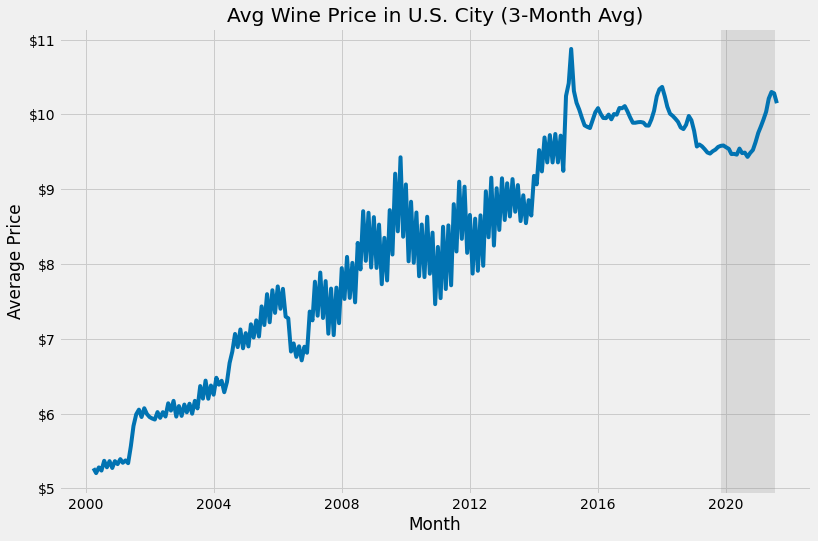

In [42]:
price_line_plot = sns.lineplot(data=train_df['price'].rolling(3).mean())
price_line_plot.set(title='Avg Wine Price in U.S. City (3-Month Avg)', ylabel='Average Price', xlabel='Month')
# shade in the timespan of the additional tariff
price_line_plot.axvspan(
    xmin=train_df['tariff'].where(train_df['tariff']).first_valid_index(), 
    xmax=train_df['tariff'].where(train_df['tariff']).last_valid_index(), 
    color='gray', 
    alpha=0.2
)
price_line_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:.0f}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/avg-wine-price-in-us-city.png')
plt.show()

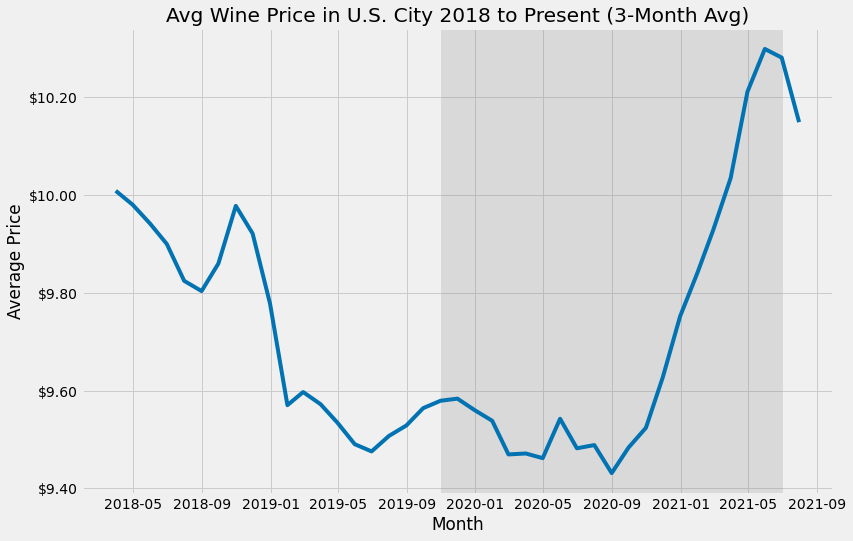

In [43]:
price_line_2018_plot = sns.lineplot(data=train_df.loc['2018-01-01':'2021-12-31']['price'].rolling(3).mean())
price_line_2018_plot.set(title='Avg Wine Price in U.S. City 2018 to Present (3-Month Avg)', ylabel='Average Price', xlabel='Month')
# shade in the timespan of the additional tariff
price_line_2018_plot.axvspan(
    xmin=train_df['tariff'].where(train_df['tariff']).first_valid_index(), 
    xmax=train_df['tariff'].where(train_df['tariff']).last_valid_index(), 
    color='gray', 
    alpha=0.2
)
price_line_2018_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:.2f}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/avg-wine-price-in-us-city-2018.png')
plt.show()

Alright, let's run the augmented Dickey-Fuller test.

In [44]:
adf(train_df['price'])

Augmented Dickey-Fuller Test:
t-stat:                   -1.752900
p-value:                   0.404083
lags:                      9.000000
observations:            249.000000
critical value (1%):      -3.456888
critical value (5%):      -2.873219
critical value (10%):     -2.572994
dtype: float64


Since the test statistic is greater than the critical value (at the 5% level), we fail to reject the null hypothesis; the series doesn't have a unit root and is therefore non-stationary.

So I do need to make some adjustments to the series to make it stationary.

First, let's decompose the series via seasonal and trend decomposition using LOESS. 

The decomposition plots don't look as good with the style I'm using so I'm going to reset it to the default for this.

In [46]:
style.use('default')

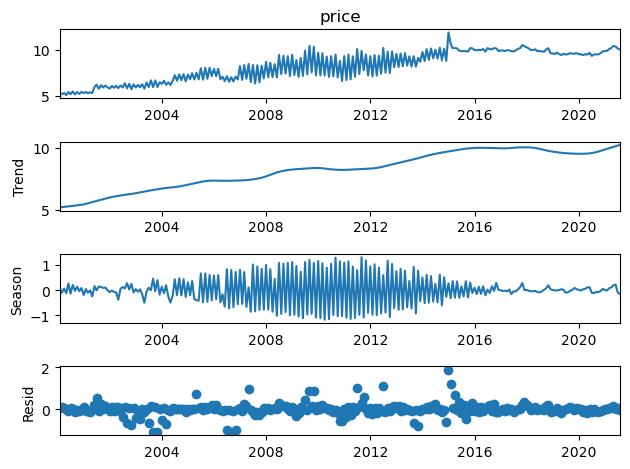

In [52]:
price_dc = STL(train_df['price'].dropna(), seasonal_deg=1, trend_deg=1, robust=True).fit()
price_dc.plot()
plt.show()

<AxesSubplot:xlabel='month'>

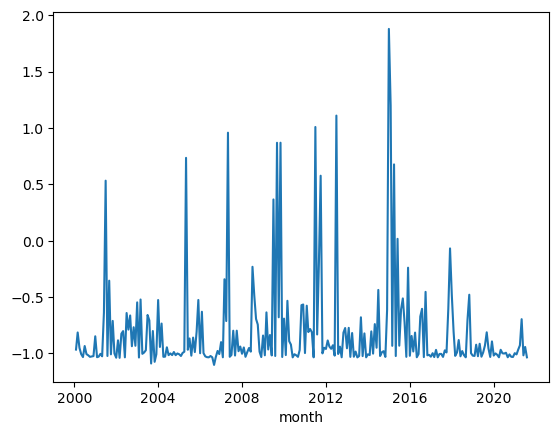

In [82]:
price_s = price_dc.observed - price_dc.seasonal - price_dc.trend - price_dc.weights

sns.lineplot(data=price_s)

In [55]:
adf(price_s)

Augmented Dickey-Fuller Test:
t-stat:                 -8.041693e+00
p-value:                 1.839725e-12
lags:                    1.000000e+00
observations:            2.570000e+02
critical value (1%):    -3.456054e+00
critical value (5%):    -2.872853e+00
critical value (10%):   -2.572799e+00
dtype: float64


Now that price is decomposed, I'm going to store off the decomposition and the seasonally-adjusted values as `price_dc` and `price_s`, respectively.

In [80]:
train_df['price_seas'] = price_dc.seasonal
train_df['price_trend'] = price_dc.trend
train_df['price_weights'] = price_dc.weights
train_df['price_s'] = price_s

In [76]:
train_df.head()

,price,pop,bott,bott_pc,exp_q,exp_val,tariff,duty_val_world,q_world,cif_world,...,cif_row,duty_row,prop_row,cif_r_row,duty_r_row,price_dc,price_s,price_seas,price_trend,price_weights
month,,,,,,,,,,,,,,,,,,,,,
2000-01-31,5.299029,281083000,1.244070e+08,0.442599,22385348,4.419970e+07,False,1.298947e+08,30869692,6.853057e+06,...,550866.019417,162756.310680,0.084392,0.229296,0.067747,<statsmodels.tsa.seasonal.DecomposeResult obje...,-0.965829,0.090855,5.179916,0.994087
2000-02-29,5.198813,281299000,1.375283e+08,0.488904,20954045,4.088633e+07,False,1.389756e+08,27334547,6.089141e+06,...,504564.787339,163492.581602,0.083999,0.238210,0.077186,<statsmodels.tsa.seasonal.DecomposeResult obje...,-0.814206,-0.106608,5.198646,0.920982
2000-03-31,5.311650,281531000,1.603837e+08,0.569684,20240059,4.023967e+07,False,1.635349e+08,33950034,7.495030e+06,...,710128.155340,191233.009709,0.093419,0.244820,0.065929,<statsmodels.tsa.seasonal.DecomposeResult obje...,-0.950924,0.055213,5.218018,0.989344
2000-04-30,5.104950,281763000,1.423004e+08,0.505036,21745478,4.100174e+07,False,1.727178e+08,37381318,8.363492e+06,...,598792.079208,177575.247525,0.074062,0.232302,0.068890,<statsmodels.tsa.seasonal.DecomposeResult obje...,-1.006072,-0.126735,5.238039,0.999719
2000-05-31,5.426889,281996000,1.612658e+08,0.571873,22059299,4.187646e+07,False,1.744802e+08,38726698,8.921802e+06,...,626929.342493,193309.126595,0.070618,0.245428,0.075676,<statsmodels.tsa.seasonal.DecomposeResult obje...,-1.032163,0.254558,5.258682,0.945813


### Bottled

In [77]:
adf(train_df['bott'])

Augmented Dickey-Fuller Test:
t-stat:                   -0.739563
p-value:                   0.836234
lags:                     14.000000
observations:            244.000000
critical value (1%):      -3.457438
critical value (5%):      -2.873459
critical value (10%):     -2.573122
dtype: float64


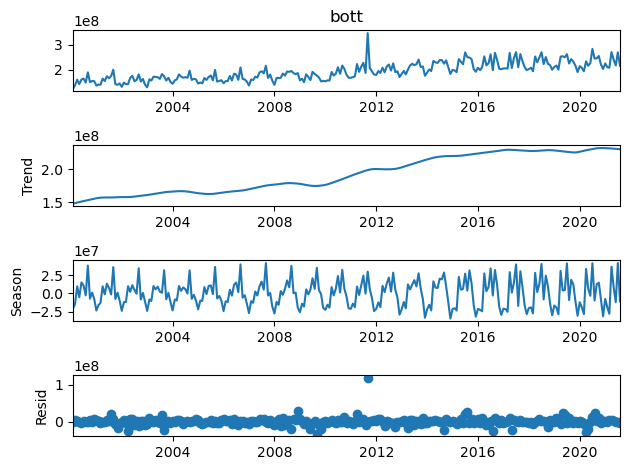

In [78]:
bott_dc = STL(train_df['bott'].dropna(), seasonal_deg=1, trend_deg=1, robust=True).fit()
bott_dc.plot()
plt.show()

<AxesSubplot:xlabel='month'>

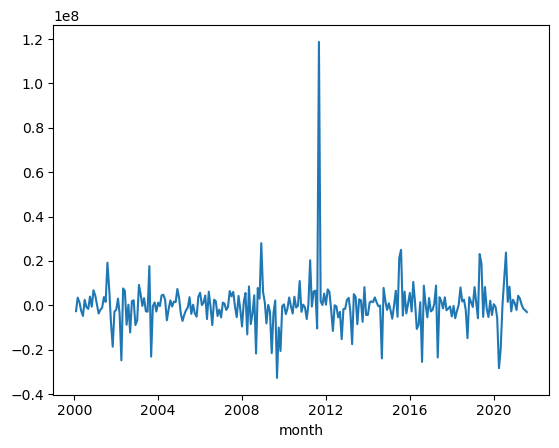

In [81]:
bott_s = bott_dc.observed - bott_dc.seasonal - bott_dc.trend - bott_dc.weights

sns.lineplot(data=bott_s)

In [83]:
adf(bott_s)

Augmented Dickey-Fuller Test:
t-stat:                   -5.320494
p-value:                   0.000005
lags:                      9.000000
observations:            249.000000
critical value (1%):      -3.456888
critical value (5%):      -2.873219
critical value (10%):     -2.572994
dtype: float64


In [84]:
train_df['bott_seas'] = bott_dc.seasonal
train_df['bott_trend'] = bott_dc.trend
train_df['bott_weights'] = bott_dc.weights
train_df['bott_s'] = bott_s

### Exports Quantity

In [90]:
adf(train_df['exp_q'])

Augmented Dickey-Fuller Test:
t-stat:                   -2.235256
p-value:                   0.193699
lags:                     13.000000
observations:            245.000000
critical value (1%):      -3.457326
critical value (5%):      -2.873410
critical value (10%):     -2.573096
dtype: float64


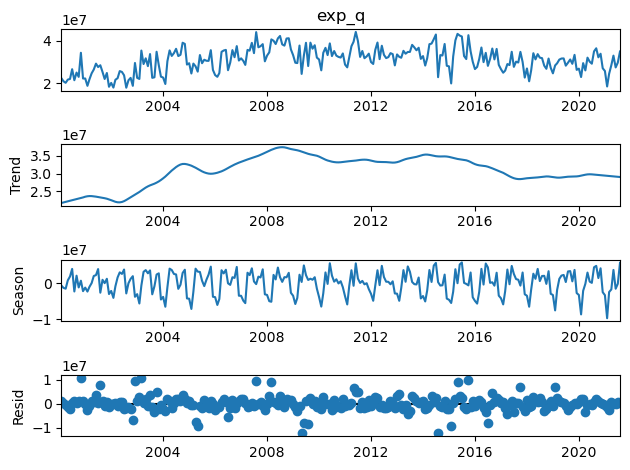

In [87]:
exp_q_dc = STL(train_df['exp_q'].dropna(), seasonal_deg=1, trend_deg=1, robust=True).fit()
exp_q_dc.plot()
plt.show()

<AxesSubplot:xlabel='month'>

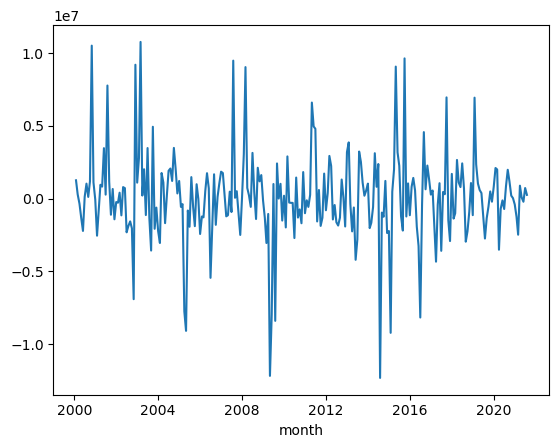

In [88]:
exp_q_s = exp_q_dc.observed - exp_q_dc.seasonal - exp_q_dc.trend - exp_q_dc.weights

sns.lineplot(data=exp_q_s)

In [89]:
adf(exp_q_s)

Augmented Dickey-Fuller Test:
t-stat:                 -1.356702e+01
p-value:                 2.252409e-25
lags:                    0.000000e+00
observations:            2.580000e+02
critical value (1%):    -3.455953e+00
critical value (5%):    -2.872809e+00
critical value (10%):   -2.572775e+00
dtype: float64


In [91]:
train_df['exp_q_seas'] = exp_q_dc.seasonal
train_df['exp_q_trend'] = exp_q_dc.trend
train_df['exp_q_weights'] = exp_q_dc.weights
train_df['exp_q_s'] = exp_q_s

## Imports

Since there are another 40 columns or so, I'm going to make a helper function to adjust for seasonality and return a dictionary of items that will let us recompose the observations. After this, I'm going to loop over all of the imports values, check them for stationarity, if they're stationary, I'll return a dictionary containing the stationary values, if they're not stationary, I'll return nothing. If the dictionary is returned, I'll create columns in `train_df` for the adjusted value and the trend, seasonal, and weights components.

In [131]:
def make_stationary(x):
    adf_test = adfuller(x, autolag='AIC')
    if adf_test[0] > adf_test[4].get('1%'):
        dc = STL(x, seasonal_deg=1, trend_deg=1, robust=True).fit()
        adj = dc.observed - dc.trend - dc.seasonal - dc.weights
        
        dc_dict = {
            'adjusted': adj,
            'trend': dc.trend,
            'seasonal': dc.seasonal,
            'weights': dc.weights
        }
    
        return dc_dict
    else:
        return
    

In [171]:
cols_imp_stat = ['duty_val_world', 'q_world', 'cif_world', 'duty_world', 'duty_val_bloc',
       'q_bloc', 'cif_bloc', 'duty_bloc', 'prop_bloc', 'duty_r_bloc',
       'cif_r_bloc', 'duty_val_it', 'q_it', 'cif_it', 'duty_it', 'prop_it',
       'duty_r_it', 'cif_r_it', 'duty_val_au', 'q_au', 'cif_au', 'duty_au',
       'prop_au', 'duty_r_au', 'cif_r_au', 'duty_val_cl', 'q_cl', 'cif_cl',
       'duty_cl', 'prop_cl', 'duty_r_cl', 'cif_r_cl', 'duty_val_row', 'q_row',
       'cif_row', 'duty_row', 'prop_row', 'cif_r_row', 'duty_r_row']

In [172]:
for c in cols_imp_stat:
    st = make_stationary(train_df[c])
    if st is None: print(c + ' passed ADF without adjustment')
    nc_s = c + '_s'
    nc_t = c + '_trend'
    nc_se = c + '_seas'
    nc_w = c + '_weights'
    if st is not None:
        train_df[nc_s] = pd.Series(st.get('adjusted'))[0:]
        train_df[nc_t] = pd.Series(st.get('trend'))[0:]
        train_df[nc_se] = pd.Series(st.get('seasonal'))[0:]
        train_df[nc_w] = pd.Series(st.get('weights'))[0:]

duty_world passed ADF without adjustment
duty_bloc passed ADF without adjustment
duty_r_bloc passed ADF without adjustment


<AxesSubplot:xlabel='month', ylabel='duty_r_bloc'>

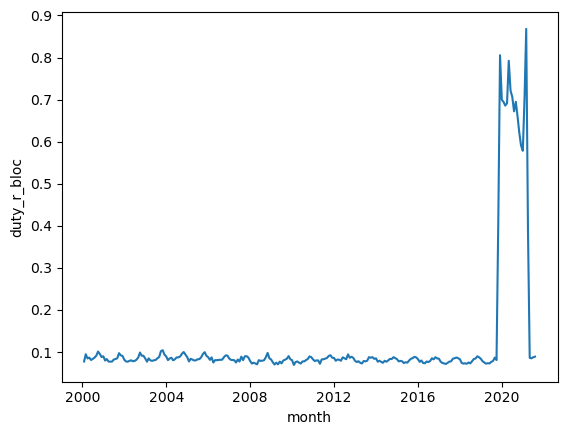

In [175]:
sns.lineplot(data=train_df['duty_r_bloc'].dropna())

I'm skeptical that `duty_r_bloc` is already stationary when the other `duty_r_*` values weren't initially. I think this is due to the tariff being imposed. So I'm going to adjust this for stationarity as well.

In [181]:
duty_r_bloc_dc = STL(train_df['duty_r_bloc'], seasonal_deg=1, trend_deg=1, robust=True).fit()

duty_r_bloc_s = duty_r_bloc_dc.observed - duty_r_bloc_dc.seasonal - duty_r_bloc_dc.trend - duty_r_bloc_dc.weights

train_df['duty_r_bloc_seas'] = duty_r_bloc_dc.seasonal
train_df['duty_r_bloc_trend'] = duty_r_bloc_dc.trend
train_df['duty_r_bloc_weights'] = duty_r_bloc_dc.weights
train_df['duty_r_bloc_s'] = duty_r_bloc_s

In [177]:
train_df

,price,pop,bott,bott_pc,exp_q,exp_val,tariff,duty_val_world,q_world,cif_world,...,cif_r_row_seas,cif_r_row_weights,duty_r_row_s,duty_r_row_trend,duty_r_row_seas,duty_r_row_weights,duty_r_bloc_seas,duty_r_bloc_trend,duty_r_bloc_weights,duty_r_bloc_s
month,,,,,,,,,,,,,,,,,,,,,
2000-01-31,5.299029,281083000,1.244070e+08,0.442599,22385348,4.419970e+07,False,1.298947e+08,30869692,6.853057e+06,...,-0.026259,0.998945,-0.971157,0.074677,-0.008269,0.972496,-0.005418,0.092341,0.000000,<statsmodels.tsa.seasonal.DecomposeResult obje...
2000-02-29,5.198813,281299000,1.375283e+08,0.488904,20954045,4.088633e+07,False,1.389756e+08,27334547,6.089141e+06,...,-0.011709,0.946954,-0.972445,0.074301,0.001571,0.973760,0.002133,0.091743,0.965049,<statsmodels.tsa.seasonal.DecomposeResult obje...
2000-03-31,5.311650,281531000,1.603837e+08,0.569684,20240059,4.023967e+07,False,1.635349e+08,33950034,7.495030e+06,...,-0.014537,0.958987,-0.862916,0.073927,-0.004911,0.859829,-0.007073,0.091152,0.978292,<statsmodels.tsa.seasonal.DecomposeResult obje...
2000-04-30,5.104950,281763000,1.423004e+08,0.505036,21745478,4.100174e+07,False,1.727178e+08,37381318,8.363492e+06,...,-0.023773,0.997759,-0.987712,0.073555,-0.003734,0.986782,-0.004251,0.090568,0.990816,<statsmodels.tsa.seasonal.DecomposeResult obje...
2000-05-31,5.426889,281996000,1.612658e+08,0.571873,22059299,4.187646e+07,False,1.744802e+08,38726698,8.921802e+06,...,-0.008284,0.996082,-0.986496,0.073184,0.001581,0.987407,-0.008454,0.089990,0.983484,<statsmodels.tsa.seasonal.DecomposeResult obje...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31,10.173180,331061000,2.713890e+08,0.819755,28503040,9.578440e+07,True,3.146280e+08,104837000,1.600186e+07,...,-0.005538,0.966842,-0.970041,0.027728,0.000590,0.968604,-0.003191,0.390596,1.000000,<statsmodels.tsa.seasonal.DecomposeResult obje...
2021-04-30,10.403817,331126000,2.409610e+08,0.727702,33029459,9.818340e+07,True,3.982079e+08,109725863,1.877114e+07,...,-0.002682,0.998791,-0.935398,0.027427,0.001511,0.933294,-0.005166,0.389980,0.000000,<statsmodels.tsa.seasonal.DecomposeResult obje...
2021-05-31,10.319847,331204000,2.174436e+08,0.656525,27474553,9.907126e+07,True,4.168890e+08,116560687,1.995182e+07,...,0.008721,0.879827,-0.985446,0.027133,-0.001454,0.984440,-0.002743,0.389365,0.000000,<statsmodels.tsa.seasonal.DecomposeResult obje...


In [178]:
for c in train_df.columns:
    print(c)

price
pop
bott
bott_pc
exp_q
exp_val
tariff
duty_val_world
q_world
cif_world
duty_world
duty_val_bloc
q_bloc
cif_bloc
duty_bloc
prop_bloc
duty_r_bloc
cif_r_bloc
duty_val_it
q_it
cif_it
duty_it
prop_it
duty_r_it
cif_r_it
duty_val_au
q_au
cif_au
duty_au
prop_au
duty_r_au
cif_r_au
duty_val_cl
q_cl
cif_cl
duty_cl
prop_cl
duty_r_cl
cif_r_cl
duty_val_row
q_row
cif_row
duty_row
prop_row
cif_r_row
duty_r_row
price_dc
price_s
price_seas
price_trend
price_weights
bott_seas
bott_trend
bott_weights
bott_s
exp_q_seas
exp_q_trend
exp_q_weights
exp_q_s
q_bloc_s
q_bloc_trend
q_bloc_seas
q_bloc_weights
duty_val_world_s
duty_val_world_trend
duty_val_world_seas
duty_val_world_weights
q_world_s
q_world_trend
q_world_seas
q_world_weights
cif_world_s
cif_world_trend
cif_world_seas
cif_world_weights
duty_val_bloc_s
duty_val_bloc_trend
duty_val_bloc_seas
duty_val_bloc_weights
cif_bloc_s
cif_bloc_trend
cif_bloc_seas
cif_bloc_weights
prop_bloc_s
prop_bloc_trend
prop_bloc_seas
prop_bloc_weights
cif_r_bloc_s
cif_

## Johansen Test

In [216]:
johan_test_df = train_df[['price_s', 'bott_s', 'exp_q_s', 'tariff', 
                          'q_bloc_s', 'cif_r_bloc_s', 'prop_bloc_s', 'duty_r_bloc_s', 
                          'q_it_s', 'cif_r_it_s', 'prop_it_s', 'duty_r_it_s',
                          'q_au_s', 'cif_r_au_s', 'prop_au_s', 'duty_r_au_s',
                          'q_cl_s', 'cif_r_cl_s', 'prop_cl_s', 'duty_r_cl_s',
                          'q_row_s', 'cif_r_row_s', 'prop_row_s', 'duty_r_row_s']].copy()


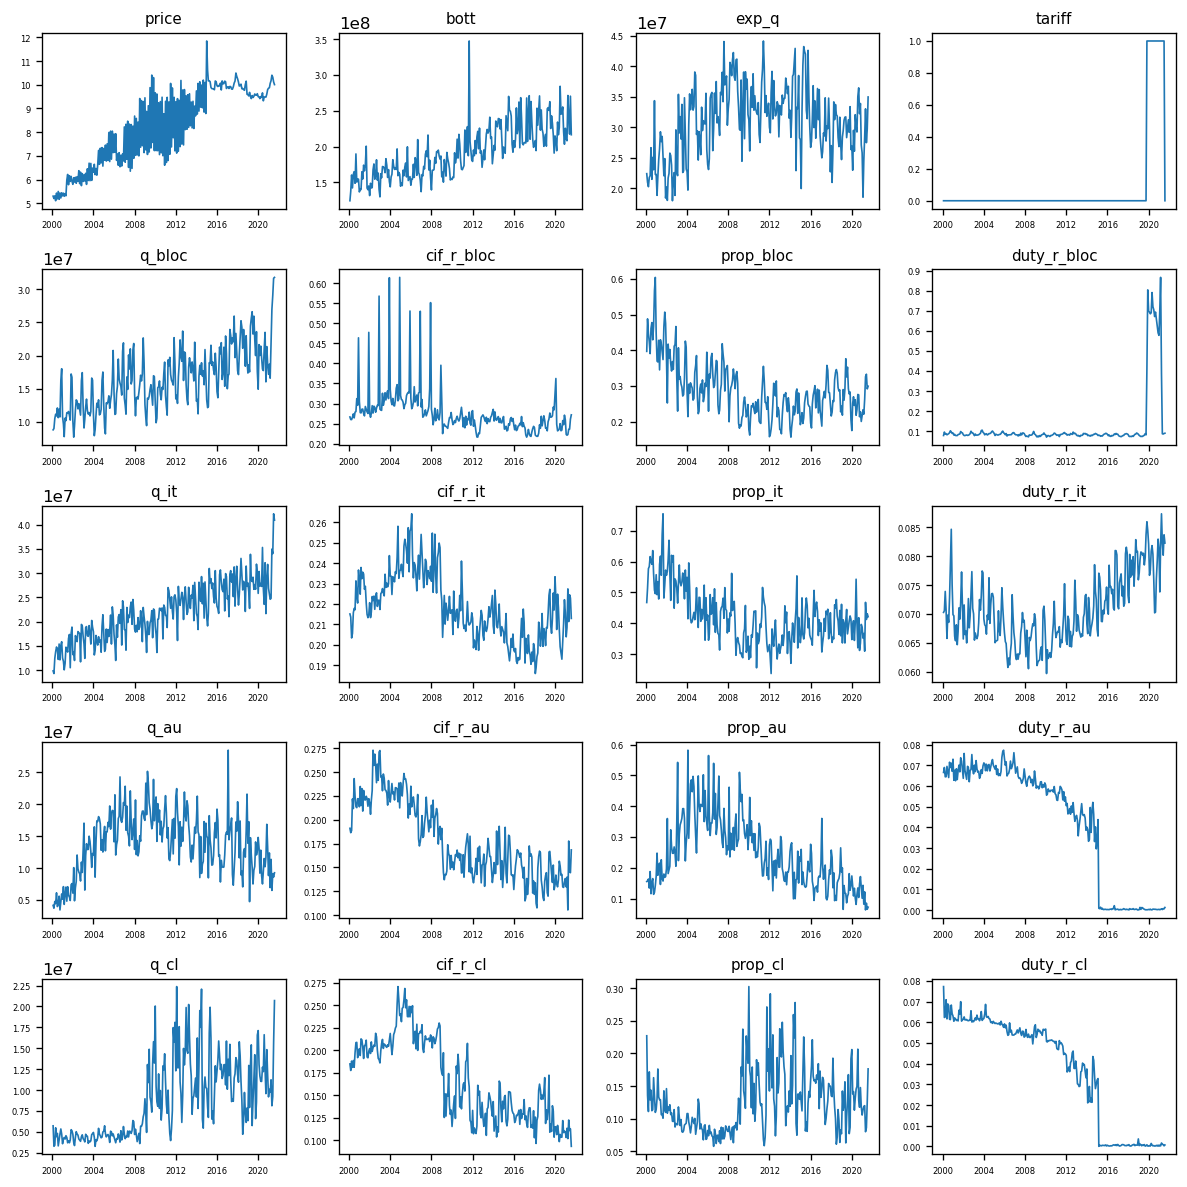

In [210]:
fig, axes = plt.subplots(nrows=5, ncols=4, dpi=120, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    data = johan_test_df[johan_test_df.columns[i]]
    ax.plot(data, linewidth=1)

    ax.set_title(johan_test_df.columns[i], size=9)
    ax.tick_params(labelsize=5)

plt.tight_layout()
plt.show()

Let's define a function that provides a printout of the results of a cointegration johansen test of the variables for our analysis.

In [217]:
def johansen_test(var_df, critical_value=0.05): 
    output = coint_johansen(var_df, -1, 3)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    trace_stat = output.lr1
    cvt_values = output.cvt[:, d[str(1-critical_value)]]
    cvm_values = output.cvm[:, d[str(1-critical_value)]]

    print('Cointegration Johansen Test:')
    print('{:<30}'.format('Variable') + '{:<30}'.format('T-Stat > CVs (trace, eig)') + '{:<20}'.format('Significant'))
    print('--'*36)
    for col, trace, cvt, eig in zip(var_df.columns, trace_stat, cvt_values, cvm_values):
        print('{:<30}'.format(col) + '{:<30}'.format('{:<7}'.format(format(trace, '.2f')) + \
            ' > ' + '{:<9}'.format('(' + format(cvt, '.2f') + ', ') + '{:<7}'.format(format(eig, '.2f')  + ')')) + '{:<20}'.format(str(trace > cvt)))

Well, I need to drop some variables because the test works with 12 at the most.

In [218]:
johan_test_df_sm = johan_test_df[['price_s', 
                                  'bott_s', 
#                                   'exp_q_s', 
#                                   'tariff',
#                                   'q_bloc_s', 
                                  'cif_r_bloc_s', 
                                  'prop_bloc_s', 
                                  'duty_r_bloc_s', 
#                                   'q_it_s', 
#                                   'cif_r_it_s', 
                                  'prop_it_s', 
                                  'duty_r_it_s',
#                                   'q_au_s', 
#                                   'cif_r_au_s', 
                                  'prop_au_s', 
                                  'duty_r_au_s',
#                                   'q_cl_s', 
#                                   'cif_r_cl_s', 
                                  'prop_cl_s', 
                                  'duty_r_cl_s',
#                                   'q_row_s', 
#                                   'cif_r_row_s', 
                                  'prop_row_s', 
#                                   'duty_r_row_s'
                                 ]].copy()

In [219]:
johansen_test(johan_test_df_sm)

Cointegration Johansen Test:
Variable                      T-Stat > CVs (trace, eig)     Significant         
------------------------------------------------------------------------
price_s                       640.41  > (311.13, 73.09)     True                
bott_s                        521.13  > (263.26, 67.08)     True                
cif_r_bloc_s                  424.29  > (219.41, 61.04)     True                
prop_bloc_s                   344.52  > (179.52, 54.96)     True                
duty_r_bloc_s                 270.47  > (143.67, 48.88)     True                
prop_it_s                     205.50  > (111.78, 42.77)     True                
duty_r_it_s                   152.48  > (83.94,  36.63)     True                
prop_au_s                     102.95  > (60.06,  30.44)     True                
duty_r_au_s                   61.39   > (40.17,  24.16)     True                
prop_cl_s                     27.63   > (24.28,  17.80)     True                
duty_r_

In [347]:
train_df.to_excel('../data/analysis_data_sa.xlsx')

## Modeling

In [279]:
train_mod_df = train_df[['price_s', 'bott_s', 'exp_q_s', 'tariff', 
                          'q_bloc_s', 'cif_r_bloc_s', 'prop_bloc_s', 'duty_r_bloc_s', 
                          'q_it_s', 'cif_r_it_s', 'prop_it_s', 'duty_r_it_s',
                          'q_au_s', 'cif_r_au_s', 'prop_au_s', 'duty_r_au_s',
                          'q_cl_s', 'cif_r_cl_s', 'prop_cl_s', 'duty_r_cl_s',
                          'q_row_s', 'cif_r_row_s', 'prop_row_s', 'duty_r_row_s']].copy()

### Lag Order Selection

In [281]:
train_mod_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259 entries, 2000-01-31 to 2021-07-31
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price_s        259 non-null    float64
 1   bott_s         259 non-null    float64
 2   exp_q_s        259 non-null    float64
 3   tariff         259 non-null    bool   
 4   q_bloc_s       259 non-null    float64
 5   cif_r_bloc_s   259 non-null    float64
 6   prop_bloc_s    259 non-null    float64
 7   duty_r_bloc_s  259 non-null    float64
 8   q_it_s         259 non-null    float64
 9   cif_r_it_s     259 non-null    float64
 10  prop_it_s      259 non-null    float64
 11  duty_r_it_s    259 non-null    float64
 12  q_au_s         259 non-null    float64
 13  cif_r_au_s     259 non-null    float64
 14  prop_au_s      259 non-null    float64
 15  duty_r_au_s    259 non-null    float64
 16  q_cl_s         259 non-null    float64
 17  cif_r_cl_s     259 non-null    floa

In [370]:
test_df_2 = train_mod_df.drop(columns=['tariff', 'cif_r_it_s', 'cif_r_bloc_s', 'cif_r_au_s', 'cif_r_cl_s', 'cif_r_it_s', 'cif_r_row_s', 'duty_r_it_s', 'duty_r_au_s', 'duty_r_cl_s', 'duty_r_row_s'])
test_df_2.columns

Index(['price_s', 'bott_s', 'exp_q_s', 'q_bloc_s', 'prop_bloc_s',
       'duty_r_bloc_s', 'q_it_s', 'prop_it_s', 'q_au_s', 'prop_au_s', 'q_cl_s',
       'prop_cl_s', 'q_row_s', 'prop_row_s'],
      dtype='object')

In [368]:
model = VAR(endog=train_mod_df.drop(columns=['tariff', 'cif_r_it_s', 'cif_r_bloc_s', 'cif_r_au_s', 'cif_r_cl_s', 'cif_r_it_s', 'cif_r_row_s', 'duty_r_it_s', 'duty_r_au_s', 'duty_r_cl_s', 'duty_r_row_s'])
            , exog=train_mod_df[['cif_r_it_s', 'cif_r_bloc_s', 'cif_r_au_s', 'cif_r_cl_s', 'cif_r_it_s', 'cif_r_row_s', 'duty_r_it_s', 'duty_r_au_s', 'duty_r_cl_s', 'duty_r_row_s']])


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [369]:
lag_orders = model.select_order(maxlags=16)
lag_orders.summary()

,AIC,BIC,FPE,HQIC
0,192.1,194.4,2.806e+83,193.0
1,192.0,197.0,2.422e+83,194.0
2,192.4,200.3,3.889e+83,195.6
3,193.0,203.7,7.350e+83,197.3
4,193.4,206.9,1.179e+84,198.8
5,193.8,210.1,2.181e+84,200.4
6,193.8,212.9,2.582e+84,201.5
7,193.8,215.7,3.737e+84,202.6
8,193.9,218.7,7.146e+84,203.9
9,193.7,221.2,1.021e+85,204.8


Let's use 1 lag since it seems to be the first floor for AIC and BIC's lowest value is 0.

In [366]:
tsmf = model.fit(1)
tsmf.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/vector_ar/var_model.py:1450: RuntimeWarning: invalid value encountered in sqrt
  stderr = np.sqrt(np.diag(self.cov_params()))


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Mar, 2022
Time:                     16:21:00
--------------------------------------------------------------------
No. of Equations:         14.0000    BIC:                    196.241
Nobs:                     258.000    HQIC:                   193.360
Log likelihood:          -29468.6    FPE:                1.37086e+83
AIC:                      191.421    Det(Omega_mle):     3.75542e+82
--------------------------------------------------------------------
Results for equation price_s
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.515478         0.233063           -2.212           0.027
cif_r_it_s              -0.000450              NAN              NAN             NAN
cif_r_bloc_s            -0.022615         0.08

In [336]:
stable = tsmf.is_stable(verbose=True)

Eigenvalues of VAR(1) rep
0.6364933238184146
0.1638813443130455
0.1638813443130455
0.3622155713516956
0.3622155713516956
0.09837920482702571
0.40565340917982373
0.10937622300311108
0.10937622300311108
0.04181593054601211
0.3180085040968259
0.26442781285307965
0.19280349974954167
0.19280349974954167


In [337]:
dw_output = durbin_watson(tsmf.resid)

for col, val in zip(train_mod_df.columns, dw_output):
    print('{:<62}'.format(str(col), ':'), round(val, 3))

price_s                                                        1.979
bott_s                                                         2.031
exp_q_s                                                        2.009
tariff                                                         2.002
q_bloc_s                                                       2.018
cif_r_bloc_s                                                   2.241
prop_bloc_s                                                    1.847
duty_r_bloc_s                                                  1.961
q_it_s                                                         1.983
cif_r_it_s                                                     2.077
prop_it_s                                                      2.106
duty_r_it_s                                                    1.994
q_au_s                                                         1.994
cif_r_au_s                                                     2.005


In [386]:
style.use('fivethirtyeight')

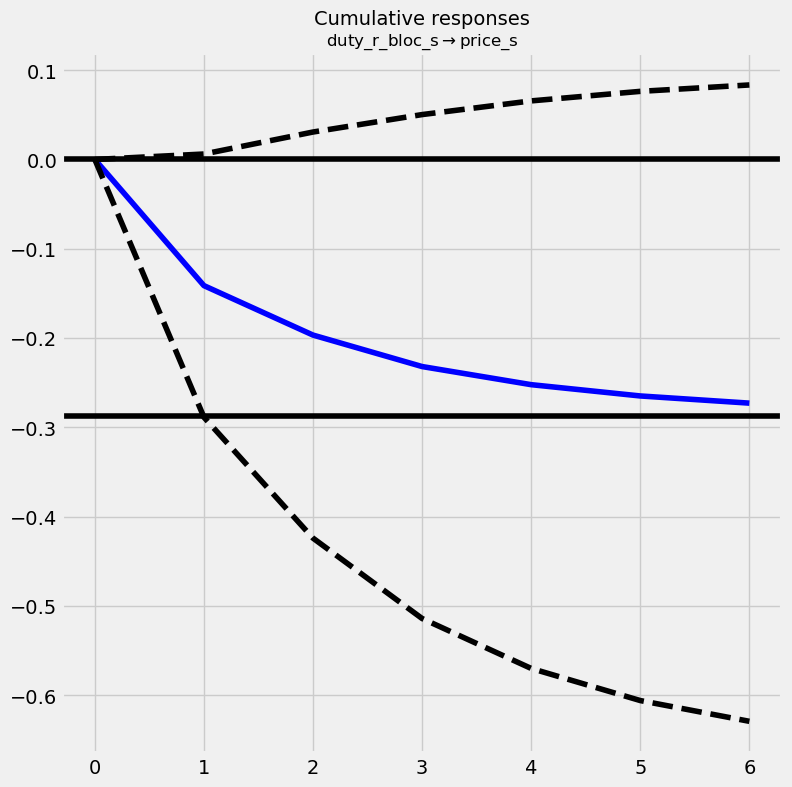

In [391]:
impulse_response = tsmf.irf(6)
ir_plt = impulse_response.plot_cum_effects(impulse='duty_r_bloc_s', response='price_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_duty_r_bloc_on_price.png')
plt.show()

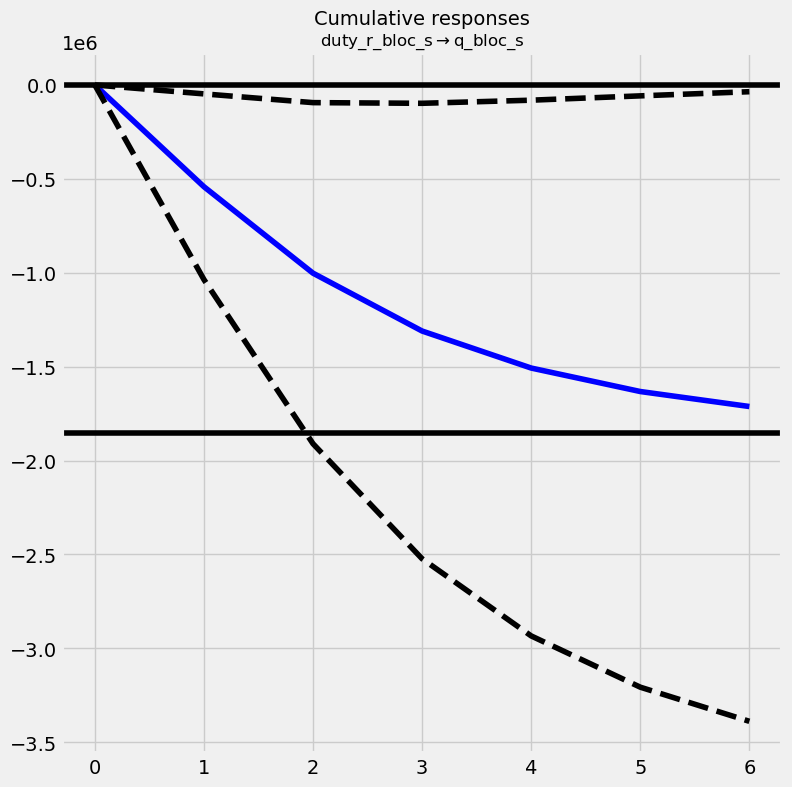

In [393]:
impulse_response = tsmf.irf(6)
impulse_response.plot_cum_effects(impulse='duty_r_bloc_s', response='q_bloc_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse--response_duty_r_bloc_on_q_bloc.png')
plt.show()

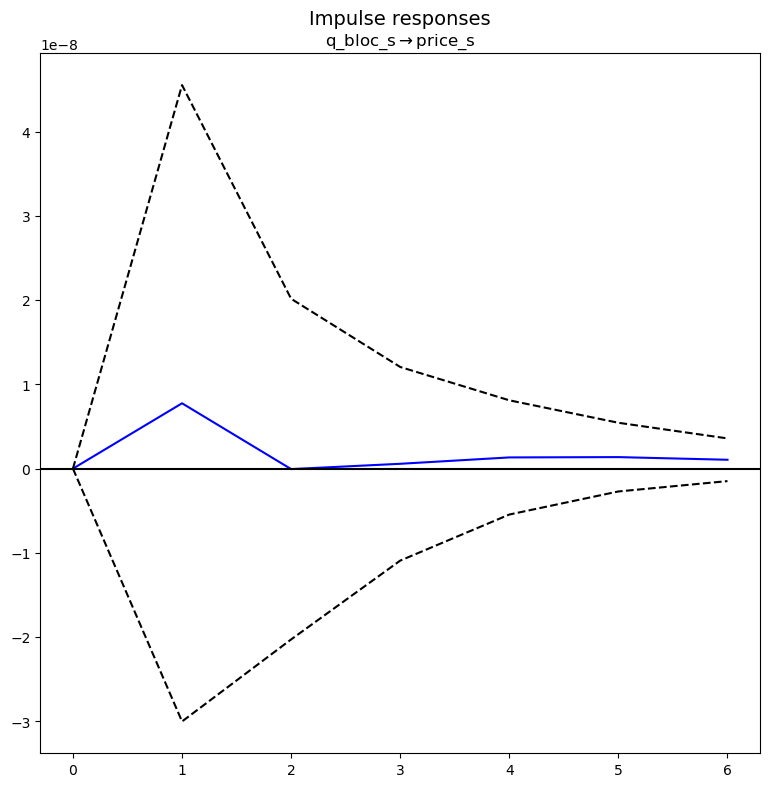

In [358]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='q_bloc_s', response='price_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_tariff_rate.png')
plt.show()

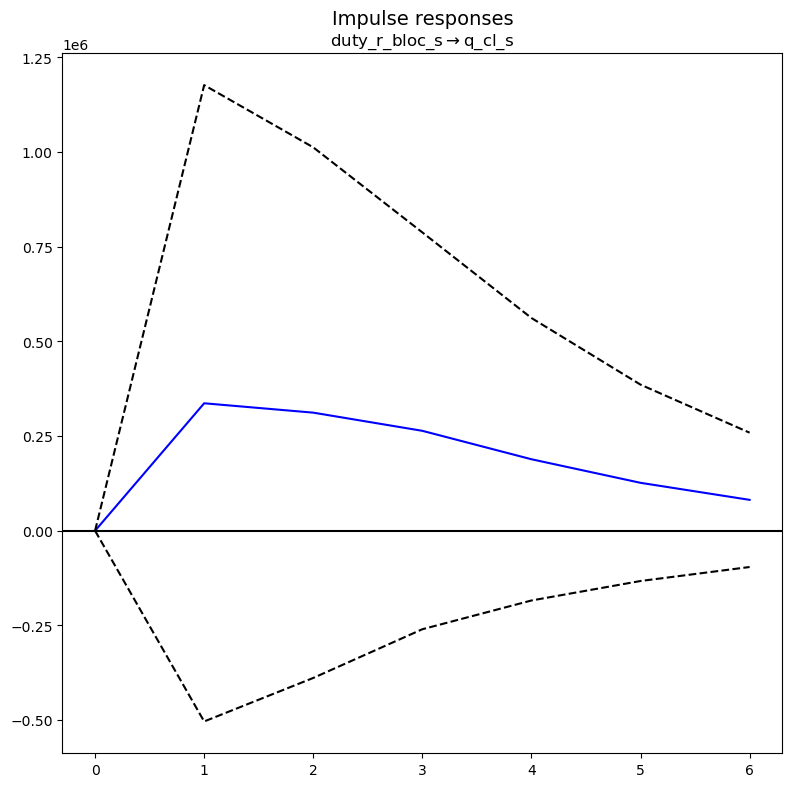

In [359]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='duty_r_bloc_s', response='q_cl_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_tariff_rate.png')
plt.show()

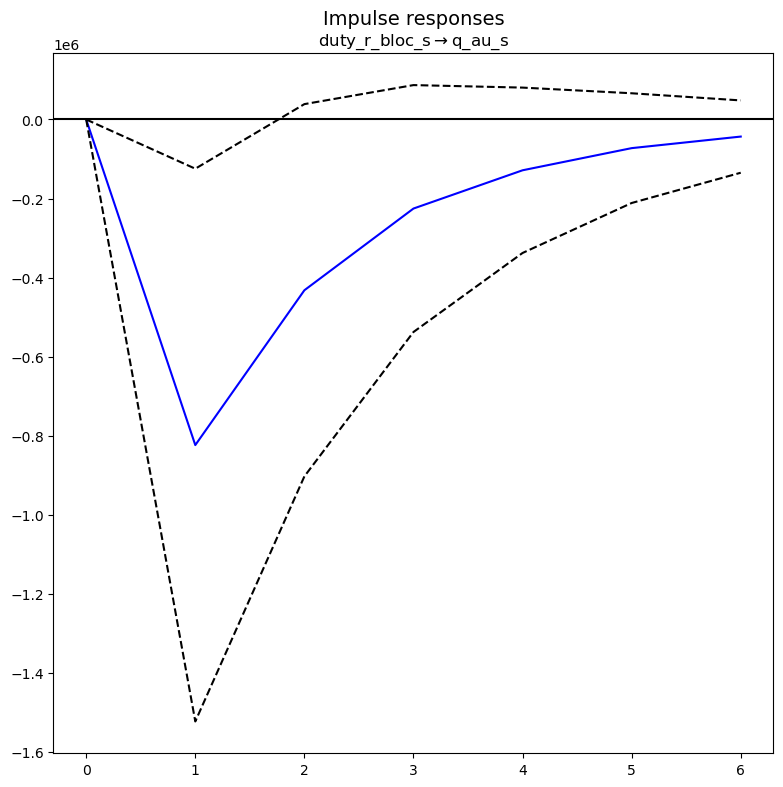

In [360]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='duty_r_bloc_s', response='q_au_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_tariff_rate.png')
plt.show()

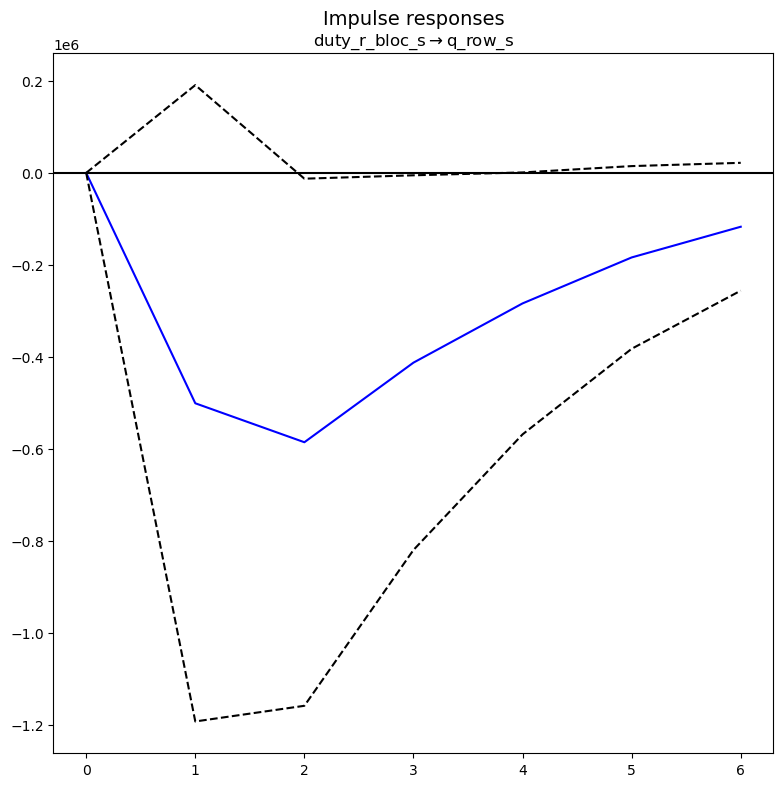

In [361]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='duty_r_bloc_s', response='q_row_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_tariff_rate.png')
plt.show()

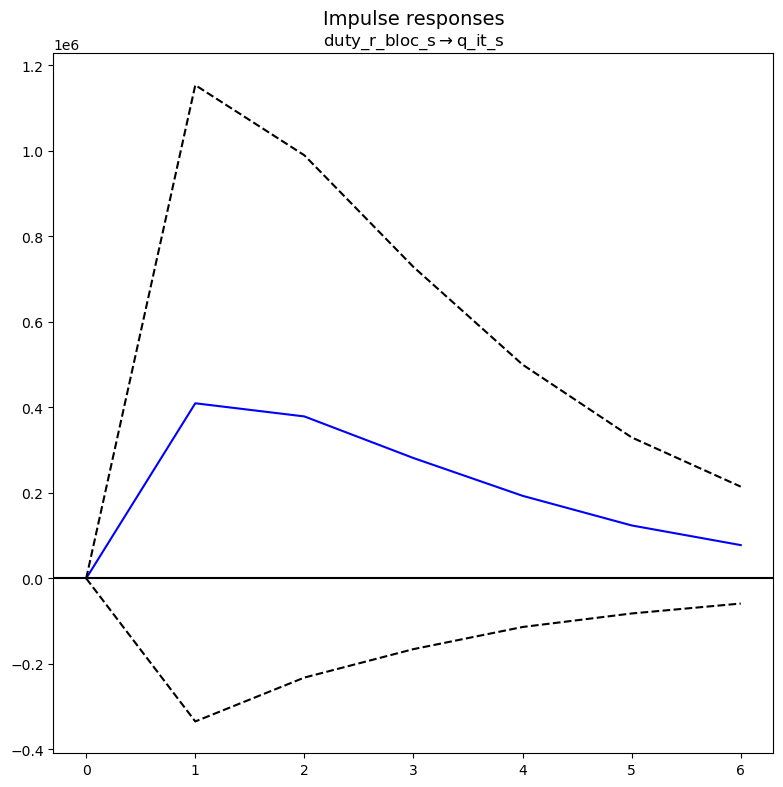

In [362]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='duty_r_bloc_s', response='q_it_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_tariff_rate.png')
plt.show()

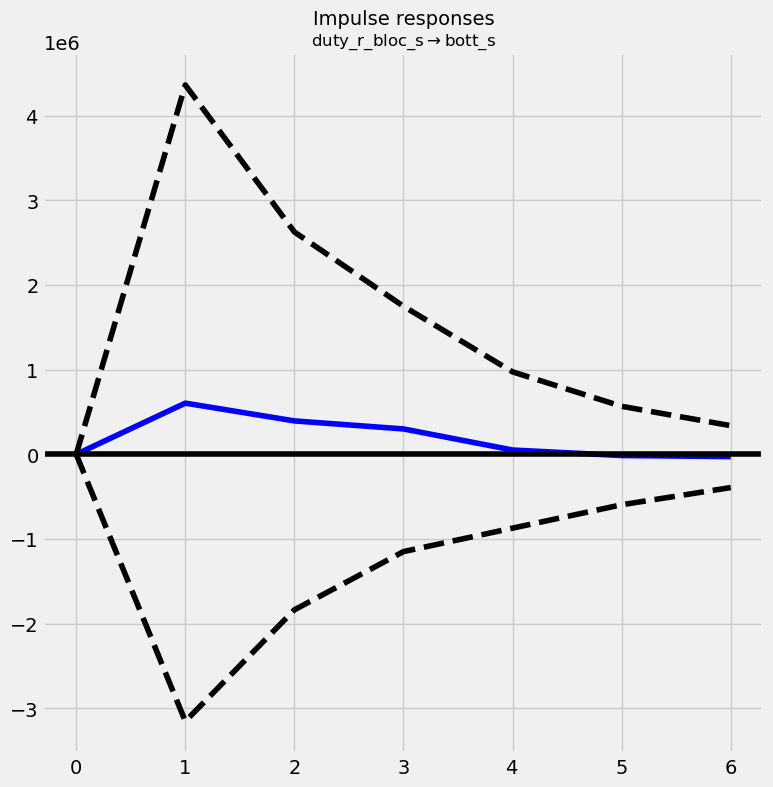

In [394]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='duty_r_bloc_s', response='bott_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_duty_r_bloc_on_bottled.png')
plt.show()

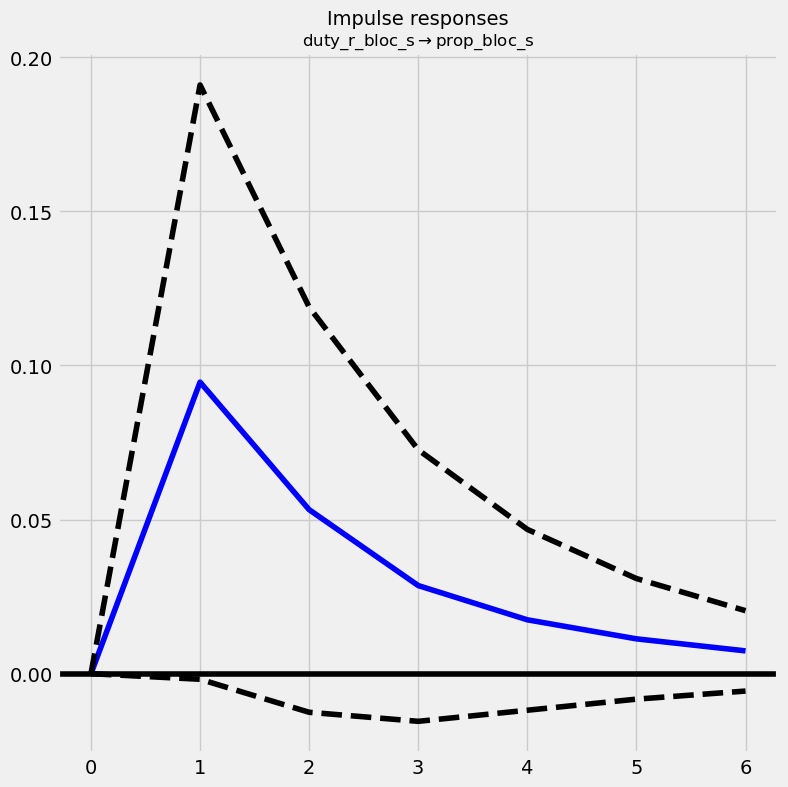

In [395]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='duty_r_bloc_s', response='prop_bloc_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_duty_r_bloc_on_prop_bloc.png')
plt.show()

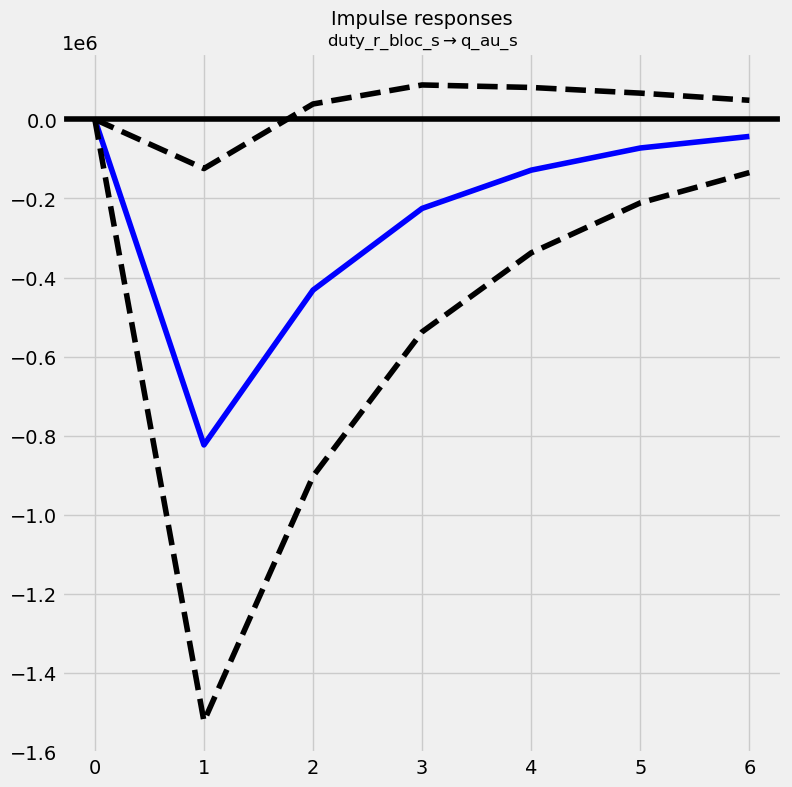

In [418]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='duty_r_bloc_s', response='q_au_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_duty_r_bloc_on_prop_it.png')
plt.show()